# Fecha de entrega: 27/08/2022 (corresponde a clase 20)

# Algoritmo de clasificación: Logistic regression

# Diccionario

**BTC_multiple_indicators_fv**	

- Date: fecha en YYYY-MM-DD (object)
- Price: precio de cierre de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Open: precio de apertura de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- High: precio más alto de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Low: precio más bajo de BTC en el día de la fecha (USD) (float) (Variable numérica continua)
- Vol.: volumen de BTC (Número de intercambios) en el día de la fecha (float) (Variable numérica continua)
- Percentage_diff: diferencia porcentual del precio de BTC en la fecha [x+1] con respecto a la fecha [x] (float) (Variable numérica continua) 
- Target: 1 indica que en el día de la fecha el precio de BTC subió, y 0 que el precio bajó (float) (Se la tratará como variable categórica)
- ADOSC: indica la fuerza de los movimientos de precios y la presión subyacente de compra y venta (float) (Variable numérica continua)
- HT_DCPHASE: Hilbert Transform - Dominant Cycle Phase (fase del ciclo dominante en una barra específica entre 0 a 360 grados dentro del período de transformada de Hilbert actual medido instantáneamente en esa barra) (grados) (float) (Variable numérica continua)
- HT_SINE_sine: Hilbert Transform - SineWave (-1 a 1) (float) (Variable numérica continua)
- HT_PHASOR_leadsine: Hilbert Transform seno del lead (-1 a 1) (float) (Variable numérica continua)
- ATR: valores del indicador Average True Range (Promedio de Rango Verdadero) (float) (Variable numérica continua)
- Linearregression: precio estimado por regresión lineal (USD) (float) (Variable numérica continua)
- Linearangle: ángulo de la mejor línea de regresión (ángulos) (float) (Variable numérica continua)
- Linearintercept: intercepción de la regresión lineal (USD) (float) (Variable numérica continua)
- Linearslope: curvatura de la regresión lineal (grados) (float) (Variable numérica continua)
- VAR: varianza (medida de dispersión definida como la esperanza del cuadrado de la desviación de dicha variable respecto a su media) (float) (Variable numérica continua)
- STDDEV: desviación estándar (medición de la dispersión de los datos) (float) (Variable numérica continua)
- Trend: tendencia de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- Seasonality: estacionariedad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- Residuals: residualidad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)
- BTC_cycle: ciclicidad de la variable [Price] a lo largo de la serie de tiempo (float) (Variable numérica continua)

# Librerías

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas_profiling
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.cm import ScalarMappable

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\lucia\anaconda3\envs\acjup\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


# Data acquisition

In [2]:
def gdriveColabPath(sharing_url):
  file_id=sharing_url.split('/')[-2]
  dwn_url='https://drive.google.com/uc?id=' + file_id
  return dwn_url

## Adquiriendo BTC_multiple_indicators_fv

In [3]:
# Se carga la base de datos de BTC_multiple_indicators_fv desde la carpeta compartida en el Google Drive
sharing_url = "https://drive.google.com/file/d/17dwqcGhoYCqLE5HWcu7TVT8lWB4lAjjT/view?usp=sharing"

In [4]:
dwn_url=gdriveColabPath(sharing_url)
BTC_multiple_indicators_fv_df = pd.read_csv(dwn_url, sep=";", decimal=".")
BTC_multiple_indicators_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,ADOSC,ATR,Linearregression,Linearangle,Linearintercept,Linearslope,VAR,STDDEV,HT_DCPHASE,HT_SINE_sine,HT_PHASOR_leadsine,Trend,Seasonality,Residuals,BTC_cycle
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.979105,NaN,-1.869639e-06
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.917886,NaN,-1.538597e-06
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.150686,NaN,-1.206386e-06
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,19.575231,-19.575231,-8.708768e-07
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.1,-15.128694,15.128694,-5.291847e-07


# Data wrangling

## Análisis pre-modelado

In [5]:
# Registros y columnas
BTC_multiple_indicators_fv_df.shape

(4386, 23)

In [6]:
# Nombre de columnas
BTC_multiple_indicators_fv_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Percentage_diff',
       'Target', 'ADOSC', 'ATR', 'Linearregression', 'Linearangle',
       'Linearintercept', 'Linearslope', 'VAR', 'STDDEV', 'HT_DCPHASE',
       'HT_SINE_sine', 'HT_PHASOR_leadsine', 'Trend', 'Seasonality',
       'Residuals', 'BTC_cycle'],
      dtype='object')

In [7]:
# Tipos de datos de las variables
BTC_multiple_indicators_fv_df.dtypes

Date                   object
Price                 float64
Open                  float64
High                  float64
Low                   float64
Vol.                  float64
Percentage_diff       float64
Target                  int64
ADOSC                 float64
ATR                   float64
Linearregression      float64
Linearangle           float64
Linearintercept       float64
Linearslope           float64
VAR                   float64
STDDEV                float64
HT_DCPHASE            float64
HT_SINE_sine          float64
HT_PHASOR_leadsine    float64
Trend                 float64
Seasonality           float64
Residuals             float64
BTC_cycle             float64
dtype: object

In [8]:
# Columnas y cantidad de registros
BTC_multiple_indicators_fv_df.count()

Date                  4386
Price                 4386
Open                  4386
High                  4386
Low                   4386
Vol.                  4386
Percentage_diff       4386
Target                4386
ADOSC                 4377
ATR                   4372
Linearregression      4373
Linearangle           4373
Linearintercept       4373
Linearslope           4373
VAR                   4382
STDDEV                4382
HT_DCPHASE            4323
HT_SINE_sine          4323
HT_PHASOR_leadsine    4323
Trend                 4380
Seasonality           4386
Residuals             4380
BTC_cycle             4386
dtype: int64

In [9]:
# Valores NaN
BTC_multiple_indicators_fv_df.isnull().sum()

Date                   0
Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Percentage_diff        0
Target                 0
ADOSC                  9
ATR                   14
Linearregression      13
Linearangle           13
Linearintercept       13
Linearslope           13
VAR                    4
STDDEV                 4
HT_DCPHASE            63
HT_SINE_sine          63
HT_PHASOR_leadsine    63
Trend                  6
Seasonality            0
Residuals              6
BTC_cycle              0
dtype: int64

In [10]:
BTC_multiple_indicators_fv_df.head()

,Date,Price,Open,High,Low,Vol.,Percentage_diff,Target,ADOSC,ATR,Linearregression,Linearangle,Linearintercept,Linearslope,VAR,STDDEV,HT_DCPHASE,HT_SINE_sine,HT_PHASOR_leadsine,Trend,Seasonality,Residuals,BTC_cycle
0,2010-07-18,0.1,0.0,0.1,0.1,80.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.979105,NaN,-1.869639e-06
1,2010-07-19,0.1,0.1,0.1,0.1,570.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.917886,NaN,-1.538597e-06
2,2010-07-20,0.1,0.1,0.1,0.1,260.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.150686,NaN,-1.206386e-06
3,2010-07-21,0.1,0.1,0.1,0.1,580.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,19.575231,-19.575231,-8.708768e-07
4,2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.1,-15.128694,15.128694,-5.291847e-07


Observaciones:

Se observaron varios registros NaN en "BTC_multiple_indicators_fv.csv". 

Esto implica la necesidad de tomar una decisión con respecto a este tipo de valores (instancia previa al modelado). 

Se descarta rellenar los NaN con promedios de valores previos y/o posteriores por varias razones:

1. En las variables [Trend] y [Residuals], 3 de los 6 valores NaN se encuentran al principio de la serie, y los restantes 3 al final de la misma. Esto significa que no se puede hacer un promedio con valores anteriores y posteriores a los valores NaN sino solo con anteriores o posteriores según el caso. Proceder con un promedio con los datos anteriores o posteriores en una serie de tiempo supone un problema extra (¿cuántos valores hacia atrás o hacia adelante se deben tomar?, ¿cuál es el grado de autocorrelación con los valores anteriores o posteriores?, entre otros). 


2. En la variable [Residuals] hay valores positivos y negativos en los registros anteriores y posteriores inmediatos según el caso. Esto también añade un problema extra (¿qué signo se debería utilizar si se rellenan esos casilleros?).


3. Al no tratarse de un problema de regresión lineal del valor que tomaría el precio de BTC en el registro siguiente sino un problema de clasificación, la eliminación de los valores NaN no afectaría en demasía la predicción del modelo a pesar de la autocorrelación referida en el punto 2. Si se considera eliminar los 12 registros NaN (6 en [Residual] y 6 en [Trend] ) se estaría solamente eliminando un (6*100/4386 =) 0.136 % de los datos. 

4. En el resto de los casos los valores NaN (tal como fue explicado oportunamente en cada notebook) se debe a la fórmula que se utilizó para calcular cada una de las variables.

Dado que el modelo no acepta valores NaN por lo dicho arriba y en documentos de trabajo anteriores, se procede a su eliminación dado que solo representan al (63*100/4386) 1.44 % de los valores del data set.  

## Ultimas manipulaciones pre-modelado

Se reindexa el data set que se modelará a fin de que la variable [Date] funcione como nuevo índice de la base de datos.

In [11]:
# Se crea una copia de BTC_multiple_indicators_fv_df con nombre BTC_multiple y se la reindexa con la variable [Date] como nuevo índice
BTC_multiple = BTC_multiple_indicators_fv_df.set_index("Date")

In [12]:
BTC_multiple.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,ADOSC,ATR,Linearregression,Linearangle,Linearintercept,Linearslope,VAR,STDDEV,HT_DCPHASE,HT_SINE_sine,HT_PHASOR_leadsine,Trend,Seasonality,Residuals,BTC_cycle
Date,,,,,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,1,38511.511976,1166.898729,20802.237143,88.315816,20360.105714,34.010110,4.057132e+05,636.956216,188.760909,-0.152312,-0.806557,21370.371429,-0.183737,-160.287691,-154.061979
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,0,7776.544982,1147.777391,20673.194286,-64.096744,20699.962857,-2.059121,9.871333e+04,314.186781,208.648545,-0.479436,-0.959553,21784.528571,-3.979105,-994.949467,-745.841392
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1,66185.614950,1204.671863,21078.882857,88.362015,20624.274286,34.969890,4.892406e+05,699.457371,217.212389,-0.604771,-0.990777,NaN,8.917886,NaN,822.393782
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,1,150988.804515,1274.016730,21643.817143,89.338511,20517.854286,86.612527,1.087067e+06,1042.625182,222.679567,-0.677898,-0.999180,NaN,1.150686,NaN,1532.500614
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,0,152531.617704,1216.158392,22101.408571,89.554376,20429.977143,128.571648,1.090209e+06,1044.130891,170.267628,0.169046,-0.577396,NaN,19.575231,NaN,1096.422183


Dado que en la práctica real solo se tiene hasta los valores del registro anterior al que se quiere predecir se intenta hacer un shift (-1) a la variable [Target]. Se entiende que así (en caso de que el modelo prediga con previsibilidad suficiente) se podría estar seguro de que después vendría el valor de [Target] original sin shift (-1).

In [13]:
# Se genera un back up
BTC_multiple_2 = BTC_multiple.copy()

In [14]:
# Se realiza el shift 
BTC_multiple_2 ["Target"] = BTC_multiple ["Target"].shift(-1)

In [15]:
BTC_multiple_2.tail()

,Price,Open,High,Low,Vol.,Percentage_diff,Target,ADOSC,ATR,Linearregression,Linearangle,Linearintercept,Linearslope,VAR,STDDEV,HT_DCPHASE,HT_SINE_sine,HT_PHASOR_leadsine,Trend,Seasonality,Residuals,BTC_cycle
Date,,,,,,,,,,,,,,,,,,,,,,
2022-07-16,21209.9,20825.2,21561.3,20484.4,136890.0,1.85,0.0,38511.511976,1166.898729,20802.237143,88.315816,20360.105714,34.010110,4.057132e+05,636.956216,188.760909,-0.152312,-0.806557,21370.371429,-0.183737,-160.287691,-154.061979
2022-07-17,20785.6,21209.8,21654.4,20755.2,132810.0,-2.00,1.0,7776.544982,1147.777391,20673.194286,-64.096744,20699.962857,-2.059121,9.871333e+04,314.186781,208.648545,-0.479436,-0.959553,21784.528571,-3.979105,-994.949467,-745.841392
2022-07-18,22525.8,20785.6,22714.9,20770.6,279720.0,8.37,1.0,66185.614950,1204.671863,21078.882857,88.362015,20624.274286,34.969890,4.892406e+05,699.457371,217.212389,-0.604771,-0.990777,NaN,8.917886,NaN,822.393782
2022-07-19,23410.2,22529.3,23757.3,21581.8,308910.0,3.93,0.0,150988.804515,1274.016730,21643.817143,89.338511,20517.854286,86.612527,1.087067e+06,1042.625182,222.679567,-0.677898,-0.999180,NaN,1.150686,NaN,1532.500614
2022-07-20,23149.1,23412.0,23429.9,22965.9,290210.0,-1.12,NaN,152531.617704,1216.158392,22101.408571,89.554376,20429.977143,128.571648,1.090209e+06,1044.130891,170.267628,0.169046,-0.577396,NaN,19.575231,NaN,1096.422183


Se elimina el registro NaN de la variable [Target] dado que los modelos no pueden procesar este tipo de datos

In [16]:
BTC_multiple_2 = BTC_multiple_2 [0:4385]

In [17]:
BTC_multiple_2.isnull().sum()

Price                  0
Open                   0
High                   0
Low                    0
Vol.                   0
Percentage_diff        0
Target                 0
ADOSC                  9
ATR                   14
Linearregression      13
Linearangle           13
Linearintercept       13
Linearslope           13
VAR                    4
STDDEV                 4
HT_DCPHASE            63
HT_SINE_sine          63
HT_PHASOR_leadsine    63
Trend                  5
Seasonality            0
Residuals              5
BTC_cycle              0
dtype: int64

Se eliminan los valores NaN del resto de las columnas.

In [18]:
BTC_multiple_2 = BTC_multiple_2.dropna()

In [19]:
BTC_multiple_2.isnull().sum()

Price                 0
Open                  0
High                  0
Low                   0
Vol.                  0
Percentage_diff       0
Target                0
ADOSC                 0
ATR                   0
Linearregression      0
Linearangle           0
Linearintercept       0
Linearslope           0
VAR                   0
STDDEV                0
HT_DCPHASE            0
HT_SINE_sine          0
HT_PHASOR_leadsine    0
Trend                 0
Seasonality           0
Residuals             0
BTC_cycle             0
dtype: int64

In [20]:
BTC_multiple_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4320 entries, 2010-09-19 to 2022-07-17
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               4320 non-null   float64
 1   Open                4320 non-null   float64
 2   High                4320 non-null   float64
 3   Low                 4320 non-null   float64
 4   Vol.                4320 non-null   float64
 5   Percentage_diff     4320 non-null   float64
 6   Target              4320 non-null   float64
 7   ADOSC               4320 non-null   float64
 8   ATR                 4320 non-null   float64
 9   Linearregression    4320 non-null   float64
 10  Linearangle         4320 non-null   float64
 11  Linearintercept     4320 non-null   float64
 12  Linearslope         4320 non-null   float64
 13  VAR                 4320 non-null   float64
 14  STDDEV              4320 non-null   float64
 15  HT_DCPHASE          4320 non-null   float64
 

# Modelado (Logistic regression)

**...Recordando que...**

*Objetivo general del proyecto*

I.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) el dinamismo del precio de Bitcoin en el corto plazo, es decir, si el precio de este criptoactivo subirá o bajará en la temporalidad estudiada (1 día).

**...Recordando que...**

*Objetivo específico del proyecto*

III.	Diseñar diversos modelos de machine learning capaces de predecir con cierto grado de previsibilidad positiva (>50/55%) y a corto plazo, el movimiento alcista o bajista del precio de BTC.

**Explicación**:

En lo que sigue se procederá a realizar varios modelos supervisados de clasificación de tipo "Logistic Regression". 

Estos serán configurados con diversos hiperparámetros a fin de encontrar el resultado más óptimo para este data set.

La variable target del modelo es la columna [Target] de BTC_multiple_2.

## Modelo 1

In [21]:
# Se generan las variables X e y (target)
X = BTC_multiple_2.drop (["Target"], axis=1)
y = BTC_multiple_2 ["Target"].values.reshape(-1,1)

In [22]:
# Se escalan los datos

escalador = MinMaxScaler()

X = escalador.fit_transform(X)

y= escalador.fit_transform(y)

In [23]:
# Se separa la data en train y test
# Se decide aplicar stratify
(X_train, X_test, y_train, y_test) = train_test_split(X, y,
                                        stratify=y,
                                        test_size=0.3,
                                        random_state=11)

In [24]:
# Creamos una instancia de la Regresión Logística
regresion_logistica = LogisticRegression()

In [25]:
# Entrenamos la regresión logística con los datos de entrenamiento
regresion_logistica.fit(X_train,y_train)

LogisticRegression()

In [26]:
y_train_pred = regresion_logistica.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = regresion_logistica.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.609457671957672
% de aciertos sobre el set de evaluación es: 0.6203703703703703


[[416 244]
 [248 388]]


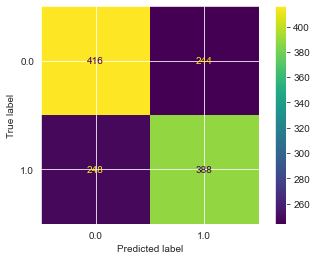

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Predicciones
predictions = regresion_logistica.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(regresion_logistica, X_test, y_test)
plt.show()

Observaciones:
- Al modelo le cuesta predecir valores positivos y negativos (los falsos positivos y negativos son altos en comparación con los verdaderos positivos y negativos).

Accuracy of the classifier is: 0.6203703703703703
Precision Score of the classifier is: 0.6139240506329114
Recall Score of the classifier is: 0.610062893081761
F1 Score of the classifier is: 0.6119873817034701
AUC for our classifier is: 0.683950352582428


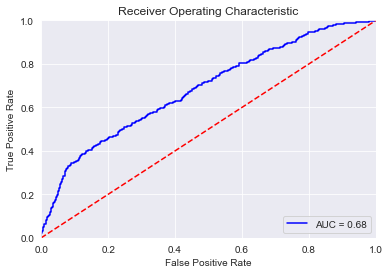

In [28]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = regresion_logistica.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Hypertuning

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
# parameter grid
parameters = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'], 
    'C'       : [0.0001,0.001,0.01,0.1,1,10,100, 1000],
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'class_weight': ['balanced'],
    'random_state': np.arange(1,10000,100),
    'warm_start':[False, True]
}

In [31]:
from sklearn.model_selection import RandomizedSearchCV
regresion_logistica = LogisticRegression()
regresion_logistica = RandomizedSearchCV(regresion_logistica,
                   parameters,  
                   scoring='accuracy',        
                   cv=5, verbose=2, n_iter=100)

In [32]:
regresion_logistica.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=0.01, class_weight=balanced, penalty=l1, random_state=4301, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, random_state=4301, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, random_state=4301, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, random_state=4301, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=l1, random_state=4301, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=elasticnet, random_state=7101, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, penalty=elasticnet, random_state=7101, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, pena

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000],
                                        'class_weight': ['balanced'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'random_state': array([   1,  101,  201,  301,  401,  501,  601,  701,  801,  901, 1001,
       1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101,
       2201, 2301, 2401, 2501, 2601, 2701, 2...
       4401, 4501, 4601, 4701, 4801, 4901, 5001, 5101, 5201, 5301, 5401,
       5501, 5601, 5701, 5801, 5901, 6001, 6101, 6201, 6301, 6401, 6501,
       6601, 6701, 6801, 6901, 7001, 7101, 7201, 7301, 7401, 7501, 7601,
       7701, 7801, 7901, 8001, 8101, 8201, 8301, 8401, 8501, 8601, 8701,
       8801, 8901, 9001, 9101, 9201, 9301, 9401, 9501, 9601, 9701, 9801,
       9901]),
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear'],
                                        'warm_start': [False, True]},
                   scoring='accuracy', verbose=2)

In [33]:
y_train_pred = regresion_logistica.predict(X_train) 
train_accuracy = accuracy_score(y_train, y_train_pred)

print('% de aciertos sobre el set de entrenamiento:',train_accuracy)

y_test_pred = regresion_logistica.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% de aciertos sobre el set de evaluación es:',test_accuracy)

% de aciertos sobre el set de entrenamiento: 0.644510582010582
% de aciertos sobre el set de evaluación es: 0.6635802469135802


[[414 246]
 [190 446]]


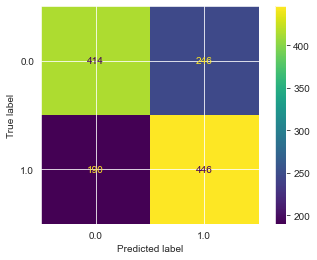

In [34]:
# Predicciones
predictions = regresion_logistica.predict(X_test)

#Matriz de Confusión
print(confusion_matrix(y_test, predictions))

#Ploteamos la Matriz
plot_confusion_matrix(regresion_logistica, X_test, y_test)
plt.show()

Observaciones:
- Se mejoraron los valores del accuracy (4%) y recall (9%) pero de todas formas el modelo posee un alto valor de falsos positivos y negativos.

Accuracy of the classifier is: 0.6635802469135802
Precision Score of the classifier is: 0.6445086705202312
Recall Score of the classifier is: 0.7012578616352201
F1 Score of the classifier is: 0.6716867469879517
AUC for our classifier is: 0.7393200876691444


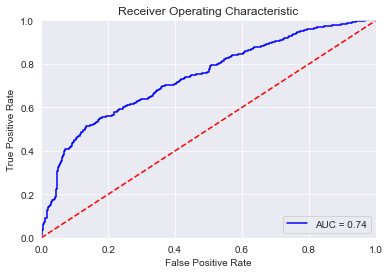

In [35]:
# Accuracy
print(f"Accuracy of the classifier is: {accuracy_score(y_test, predictions)}")

# Precision
from sklearn.metrics import precision_score
print(f"Precision Score of the classifier is: {precision_score(y_test, predictions)}")

# Recall
from sklearn.metrics import recall_score
print(f"Recall Score of the classifier is: {recall_score(y_test, predictions)}")

# Calculo del F1 score
from sklearn.metrics import f1_score
print(f"F1 Score of the classifier is: {f1_score(y_test, predictions)}")

#Template CURVA - ROC

from sklearn.metrics import roc_curve, auc

class_probabilities = regresion_logistica.predict_proba(X_test)
preds = class_probabilities[:, 1]

fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC for our classifier is: {roc_auc}")

# Gráfica de la Curva ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Observaciones:
- El modelo predice en un 66,3% de los casos si el precio de BTC sube o baja.